In [17]:
!pip uninstall -y pandas
!pip install --upgrade --no-cache-dir pandas
!pip uninstall -y xgboost
!pip install --upgrade --no-cache-dir xgboost

Found existing installation: pandas 1.0.4
Uninstalling pandas-1.0.4:
  Successfully uninstalled pandas-1.0.4
     |████████████████████████████████| 10.1 MB 1.8 MB/s eta 0:00:01
Found existing installation: xgboost 1.1.0
Uninstalling xgboost-1.1.0:
  Successfully uninstalled xgboost-1.1.0
     |████████████████████████████████| 127.6 MB 35.9 MB/s eta 0:00:01    |██████████████████▉             | 75.0 MB 34.4 MB/s eta 0:00:02     |█████████████████████           | 83.4 MB 39.6 MB/s eta 0:00:02     |████████████████████████████▋   | 114.0 MB 39.6 MB/s eta 0:00:01     |█████████████████████████████▋  | 118.1 MB 39.6 MB/s eta 0:00:01


In [98]:
!pip install bayesian-optimization

  Created wheel for bayesian-optimization: filename=bayesian_optimization-1.2.0-py3-none-any.whl size=11684 sha256=dcef4a0ab4cc750dbe11a6021f6ee837e463ec2f40c9bac41370268a829315f6
  Stored in directory: /home/jovyan/.cache/pip/wheels/fd/9b/71/f127d694e02eb40bcf18c7ae9613b88a6be4470f57a8528c5b
Successfully built bayesian-optimization


In [1]:
import numpy as np
# import pandas as pd
from sklearn.model_selection import train_test_split, KFold
import pickle
import xgboost as xgb
# from sklearn.linear_model import LinearRegression
# from sklearn import tree
from sklearn.metrics import accuracy_score

from sklearn.metrics import precision_recall_fscore_support
import warnings

import matplotlib.pyplot as plt

from bayes_opt import BayesianOptimization
# from sklearn.metrics import mean_squared_error

# from sklearn.metrics import r2_score

In [2]:
data = pickle.load(open('./fullxy_15day.pkl',mode='rb'))

In [3]:
x = data[0]
y = data[1] > 0
y = y.astype('int')
np.unique(y)

array([0, 1])

In [4]:
X_train, X_test, y_train, y_test = train_test_split(x,y, test_size=.3,random_state=42)

In [5]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((3604, 60), (3604,), (1545, 60), (1545,))

In [10]:
eval_set =[(X_test, y_test)]
xg = xgb.XGBClassifier(colsample_bytree=0.95,
                       subsample = 0.95,
                       n_estimators = 2000, 
                       max_depth=3,
                       learning_rate = 0.05)
xg.fit(X_train,y_train, eval_metric="rmse", eval_set=eval_set, verbose=False)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.95, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=2000, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.95,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [11]:
y_pred = xg.predict(X_test)
y_post = xg.predict(X_train)

precision, recall, fscore, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')
print('Precision: %.4f' % precision)
print('Recall:    %.4f' % recall)
print('F1-score:  %.4f' % fscore)

Precision: 0.6837
Recall:    0.6923
F1-score:  0.6880


In [12]:
accuracy = accuracy_score(y_test, y_pred)
print(f'Test accuracy %.2f%%' % (accuracy*100.0))

accuracy = accuracy_score(y_train, y_post)
print(f'Train accuracy %.2f%%' % (accuracy*100.0))

Test accuracy 67.77%
Train accuracy 98.70%


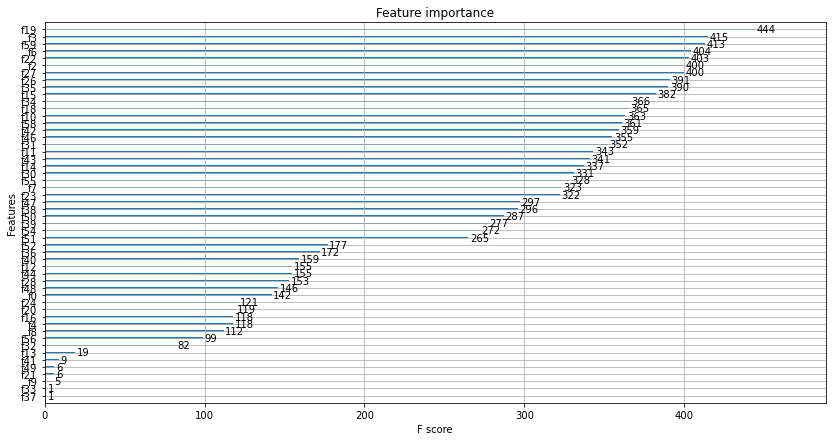

In [13]:
plt.rcParams["figure.figsize"] = (14, 7)
fig = xgb.plot_importance(xg)

In [14]:
#Bayesian Optimization function for xgboost
#specify the parameters you want to tune as keyword arguments
def bo_tune_xgb(max_depth, gamma, n_estimators ,learning_rate, subsample):
    params = {'max_depth': int(max_depth),
              'gamma': gamma, #'n_estimators': int(n_estimators),
              'learning_rate':learning_rate,
              'subsample': subsample,
              'eta': 0.1,
              'eval_metric': 'rmse'}
    
    #Cross validating with the specified parameters in 4 folds and 200000 iterations
    cv_result = xgb.cv(params,dtrain, num_boost_round=200000, nfold=4, early_stopping_rounds = 100)
    
    #print(cv_result.columns)
    
    #Return the negative RMSE (so that the 'maximum' value means the lowest RMSE (least negative))
    return -1.0 * cv_result['test-rmse-mean'].iloc[-1]

In [16]:
#put test/train data into "DMatrix" format for ease of use within XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [17]:
#Invoking the Bayesian Optimizer with the specified parameters to tune
xgb_bo = BayesianOptimization(bo_tune_xgb, {'max_depth': (3, 20),
                                             'gamma': (0, .5),
                                             'learning_rate':(0,1),
                                             'n_estimators':(15,4200),
                                             'subsample':(0.4,1)
                                            },)

#performing Bayesian optimization for 250 exploitation iterations with 75 steps of random exploration with an 
#acquisition function of 'expected improvement'
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    xgb_bo.maximize(n_iter=25, init_points=7, acq='ei')

|   iter    |  target   |   gamma   | learni... | max_depth | n_esti... | subsample |
-------------------------------------------------------------------------------------
|  1        | -0.552    |  0.2212   |  0.7793   |  18.33    |  3.675e+0 |  0.9311   |
|  2        | -0.4691   |  0.4673   |  0.01515  |  9.334    |  3.995e+0 |  0.5847   |
|  3        | -0.5044   |  0.01259  |  0.6883   |  8.296    |  3.083e+0 |  0.8489   |
|  4        | -0.4835   |  0.4646   |  0.1605   |  17.88    |  885.5    |  0.6074   |
|  5        | -0.5371   |  0.1771   |  0.7316   |  14.34    |  1.491e+0 |  0.6207   |
|  6        | -0.4927   |  0.4512   |  0.3367   |  14.1     |  1.712e+0 |  0.8922   |
|  7        | -0.4796   |  0.19     |  0.1666   |  17.35    |  2.076e+0 |  0.793    |
|  8        | -0.5011   |  0.3245   |  0.2754   |  15.81    |  2.076e+0 |  0.4432   |
|  9        | -0.5249   |  0.4719   |  0.6228   |  11.22    |  3.997e+0 |  0.5102   |
|  10       | -0.5502   |  0.1077   |  0.7636   |  16.

In [18]:
keep_params = xgb_bo.max['params']
fix_params = keep_params
fix_params['max_depth'] = round(fix_params['max_depth']).astype(int)
fix_params['n_estimators'] = round(fix_params['n_estimators']).astype(int)

for key, val in fix_params.items():
    print(key,'\t : %0.4f' % val)

gamma 	 : 0.2643
learning_rate 	 : 0.0251
max_depth 	 : 18.0000
n_estimators 	 : 2076.0000
subsample 	 : 0.8097


In [19]:
eval_set =[(X_test, y_test)]

# create an XGB classifier model with parameters learned through Bayesian Optimization
xg = xgb.XGBClassifier(**fix_params)
xg.fit(X_train,y_train, eval_metric="error", eval_set=eval_set, verbose=False)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.26432536340001966,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.025094586325093204, max_delta_step=0,
              max_depth=18, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=2076, n_jobs=0,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=0.8096907648031735,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [22]:
y_pred = xg.predict(X_test)
y_post = xg.predict(X_train)

precision, recall, fscore, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')
print('Precision: %.4f' % precision)
print('Recall:    %.4f' % recall)
print('F1-score:  %.4f' % fscore)

Precision: 0.6972
Recall:    0.7289
F1-score:  0.7127


In [23]:

accuracy = accuracy_score(y_test, y_pred)
print(f'Test accuracy %.2f%%' % (accuracy*100.0))

accuracy = accuracy_score(y_train, y_post)
print(f'Train accuracy %.2f%%' % (accuracy*100.0))

Test accuracy 69.84%
Train accuracy 100.00%


In [268]:
# uncomment to save model
#pickle.dump(xg,open("xgmodel_15day.pkl",mode='wb'))